<a href="https://colab.research.google.com/github/Gilgamesh-hoang/MachineLearning/blob/main/prject_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/'

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [ ]:
# Thư viện tiêu chuẩn
import pandas as pd
import numpy as np

# Tiền xử lý dữ liệu
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tạo test và train
from sklearn.model_selection import StratifiedShuffleSplit

# thư viện Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import plotly.express as px

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
news_df=pd.read_csv('ML/bbc-news-data.csv',sep='\t')

In [ ]:
# Hiển thị thông tin cơ bản và một số hàng đầu tiên của tập dữ liệu để xác minh cấu trúc của nó
news_df = pd.DataFrame(news_df, columns=['category', 'title', 'content'])
print(news_df.head())
print('\nShape of data is {}\n'.format(news_df.shape))
print(news_df.info())

   category                              title  \
0  business  Ad sales boost Time Warner profit   
1  business   Dollar gains on Greenspan speech   
2  business  Yukos unit buyer faces loan claim   
3  business  High fuel prices hit BA's profits   
4  business  Pernod takeover talk lifts Domecq   

                                             content  
0   Quarterly profits at US media giant TimeWarne...  
1   The dollar has hit its highest level against ...  
2   The owners of embattled Russian oil giant Yuk...  
3   British Airways has blamed high fuel prices f...  
4   Shares in UK drinks and food firm Allied Dome...  

Shape of data is (2225, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   title     2225 non-null   object
 2   content   2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB
Non

In [ ]:
news_df.columns
news_df['category'].value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

# Vẽ biểu đồ phân bố của dữ liệu

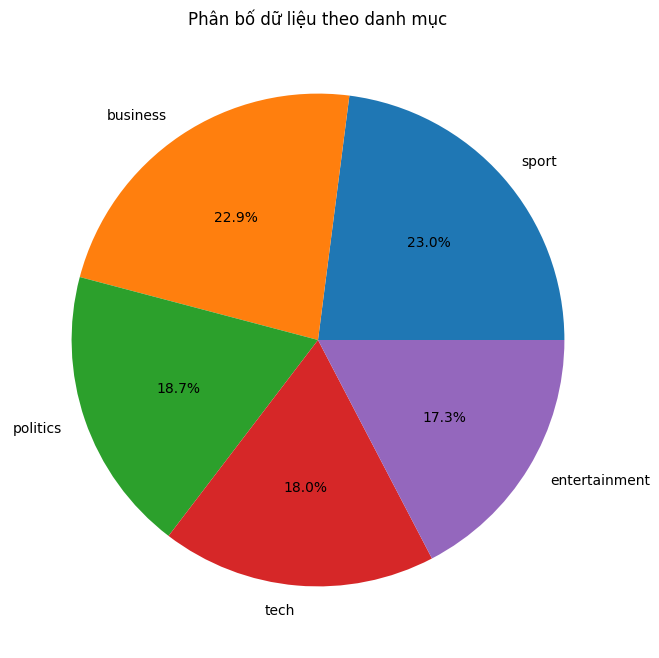

In [ ]:
category_counts = news_df["category"].value_counts()
# Vẽ biểu đồ hình tròn cho category
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%")
plt.title("Phân bố dữ liệu theo danh mục")
plt.show()

**Tiền xử lý Bước đầu tiên**

Mã hóa thứ tự: cột danh mục

In [ ]:
# Gắn nhãn cho danh mục bằng cách sử dụng factorize và lưu vào cột mới 'category_id'
news_df['category_id'] = news_df.category.factorize()[0]

# Tạo DataFrame mới chỉ chứa cặp giá trị 'category' và 'category_id', loại bỏ hàng trùng lặp và sắp xếp theo 'category_id'
category_id_df = news_df[['category','category_id']].drop_duplicates().sort_values('category_id')

# Tạo từ điển ánh xạ từ tên danh mục sang ID danh mục và từ ID danh mục sang tên danh mục
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id','category']].values)

In [ ]:
pd.DataFrame(news_df.category.value_counts()).rename(columns={'category':'Count'}).style.bar(color='#137a63')

,count
category,
sport,511
business,510
politics,417
tech,401
entertainment,386


In [ ]:
# Loại bỏ dữ liệu trùng lặp dựa trên cột 'category' và 'title'
news_df.drop_duplicates(subset=['category','title'], inplace=True)

# Kết hợp tiêu đề và nội dung thành một cột mới 'text'
news_df['text'] = news_df['title'] + ' ' + news_df['content']

**Tiền xử lý Bước thứ hai**

Phương pháp tiền xử lý văn bản
1. lower casing
2. bỏ dấu câu và số
3. xóa khoảng trắng
4. xóa điểm dừng
5. từ bổ nghĩa

In [ ]:
def clean_text(text):
    # Thay thế ký tự không phải là chữ cái bằng khoảng trắng
    text = re.sub("[^a-zA-Z]", " ", text)
    # Loại bỏ khoảng trắng thừa và ghép các từ lại với nhau
    text = ' '.join(text.split())
    # Chuyển đổi tất cả các ký tự thành chữ thường
    text = text.lower()
    return text

# Áp dụng hàm clean_text cho cột 'text' và lưu kết quả vào cột 'clean_text'
news_df['clean_text'] = news_df['text'].apply(clean_text)

In [ ]:
stop_words = set(stopwords.words('english'))

# Hàm để loại bỏ stop words từ văn bản
# VD: "the", "a", "an", "and", "or", "but",...
def remove_stopwords(text):
    # Tách văn bản thành các từ riêng biệt và loại bỏ các stop words
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

# Áp dụng hàm remove_stopwords cho cột 'clean_text' và lưu kết quả vào cùng cột
news_df['clean_text'] = news_df['clean_text'].apply(remove_stopwords)

In [ ]:
# Khởi tạo WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Hàm lemmatization để chuyển đổi từng từ trong văn bản về dạng cơ bản của chúng
def lemmatization(text):
    lem = [lemmatizer.lemmatize(w) for w in text.split()]
    return ' '.join(lem)

# Áp dụng lemmatization cho cột 'clean_text' và lưu kết quả vào cùng cột
news_df['clean_text'] = news_df['clean_text'].apply(lemmatization)

In [ ]:
stemmer = PorterStemmer()

def stemming(text):
    stemmed_text = [stemmer.stem(word) for word in text.split()]
    return ' '.join(stemmed_text)

news_df['clean_text'] = news_df['clean_text'].apply(stemming)

In [ ]:
# Đặt các từ dừng (stopwords) từ tập hợp STOPWORDS của WordCloud
stopwords = set(STOPWORDS)

# Kết hợp toàn bộ văn bản đã làm sạch thành một chuỗi duy nhất
totalTarget = ' '.join(news_df['clean_text'])

In [ ]:
# Chia chuỗi totalTarget thành danh sách các từ
totalTarget = totalTarget.split()

# Tính tần suất xuất hiện của mỗi từ trong danh sách
freq_dist = nltk.FreqDist(totalTarget)

# Chuyển đổi tần suất từ điển thành DataFrame của pandas
freq_dist = pd.DataFrame({'word': list(freq_dist.keys()), 'count': list(freq_dist.values())})

# Vẽ biểu đồ cột cho 20 từ xuất hiện nhiều nhất
px.bar(freq_dist.nlargest(20, 'count').sort_values('count'), y='word', x='count',
       title='Tần suất của 20 từ xuất hiện nhiều nhất', color_discrete_sequence=['#137a63'])

**tokenizer và vecto hóa văn bản**

In [ ]:
# Khởi tạo tokenizer với số lượng từ tối đa là 10000
tokenizer = Tokenizer(num_words=10000)

# Huấn luyện tokenizer trên văn bản đã làm sạch
tokenizer.fit_on_texts(news_df.clean_text)

# Chuyển đổi văn bản thành chuỗi các chỉ số
sequences = tokenizer.texts_to_sequences(news_df.clean_text)

# Đệm các chuỗi để chúng có độ dài bằng nhau
text = pad_sequences(sequences)

# Chuyển đổi cột category_id thành kiểu float32
labels = news_df.category_id.astype('float32')


In [ ]:
# Chuyển đổi chuỗi chỉ số thành biểu diễn vectơ
def vectorize_sequence(sequence, dimension=10000):
    # Khởi tạo một ma trận zeros với số hàng bằng số lượng chuỗi và số cột bằng dimension
    results = np.zeros((len(sequence), dimension))

    # Lặp qua từng chuỗi chỉ số
    for i, seq in enumerate(sequence):
        # Đặt các vị trí tương ứng với các chỉ số trong chuỗi thành 1
        results[i, seq] = 1
    return results

# Sử dụng hàm để biểu diễn vectơ one-hot của chuỗi text
vectorizer = vectorize_sequence(text)

# In ra biểu diễn vectơ one-hot của chuỗi text đầu tiên
vectorizer[0]

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Lặp qua các chỉ số được tạo bởi StratifiedShuffleSplit
for train_index, test_index in split.split(news_df, news_df['category_id']):
    # Tạo tập huấn luyện và tập kiểm tra dựa trên chỉ số
    strat_train_set = news_df.iloc[train_index]
    strat_test_set = news_df.iloc[test_index]

X_train = strat_train_set['clean_text']
y_train = strat_train_set['category_id']
X_test = strat_test_set['clean_text']
y_test = strat_test_set['category_id']


In [ ]:

# tập dữ liệu này dùng để train SVM
Xtrain_vectorize = vectorize_sequence(text[train_index])
Xtest_vectorize = vectorize_sequence(text[test_index])

# tập dữ liệu này dùng để train Neural network
one_hot_train_labels = to_categorical(y_train)
one_hot_test_labels = to_categorical(y_test)

In [ ]:

# Các tham số cần tìm kiếm cho SVM
svm_params = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'poly', 'rbf'],
              'gamma': ['scale', 'auto']}

# Sử dụng GridSearchCV cho SVM
svm_grid = GridSearchCV(SVC(), svm_params, cv=3)
svm_grid.fit(Xtrain_vectorize, y_train)

# In ra tham số tốt nhất cho SVM
print("Best parameters for SVM:", svm_grid.best_params_)



In [ ]:
# Các tham số cần tìm kiếm cho mạng nơ-ron
mlp_params = {'hidden_layer_sizes': [(10,), (5, 5)],
              'activation': ['relu', 'tanh'],
              'learning_rate_init': [0.001, 0.01]}

# Sử dụng GridSearchCV cho mạng nơ-ron
mlp_grid = GridSearchCV(MLPClassifier(), mlp_params, cv=3)
mlp_grid.fit(Xtrain_vectorize, y_train)

# In ra tham số tốt nhất cho mạng nơ-ron
print("Best parameters for MLP:", mlp_grid.best_params_)

Best parameters for MLP: {'activation': 'tanh', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01}


Accuracy of MLP: 0.9714285714285714


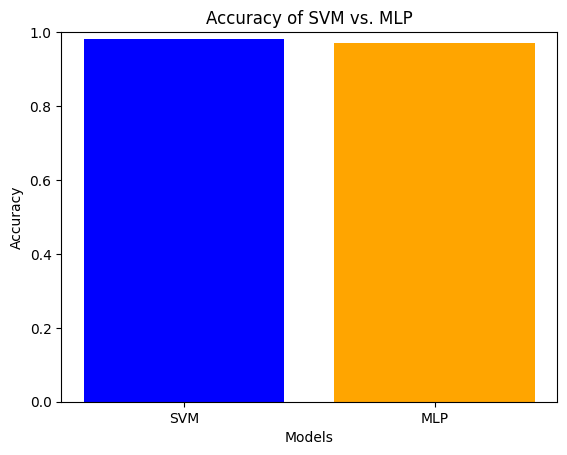

In [ ]:
# Xây dựng và huấn luyện mô hình SVM
svm_model = SVC(C=0.1, gamma='scale', kernel='linear')
svm_model.fit(Xtrain_vectorize, y_train)
svm_pred = svm_model.predict(Xtest_vectorize)
svm_accuracy = accuracy_score(y_test, svm_pred)

# Xây dựng và huấn luyện mô hình MLP
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=(10,), learning_rate_init=0.01)
mlp_model.fit(Xtrain_vectorize, y_train)
mlp_pred = mlp_model.predict(Xtest_vectorize)
mlp_accuracy = accuracy_score(y_test, mlp_pred)

# Trình bày kết quả thực nghiệm
models = ['SVM', 'MLP']
accuracies = [svm_accuracy, mlp_accuracy]

plt.bar(models, accuracies, color=['blue', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of SVM vs. MLP')
plt.ylim(0, 1)
plt.show()

Accuracy of SVM: 0.9809523809523809
Accuracy of MLP: 0.9714285714285714
Classification Report of SVM:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       100
           1       1.00      1.00      1.00        73
           2       0.95      0.99      0.97        80
           3       1.00      0.98      0.99       100
           4       0.97      0.97      0.97        67

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420

Classification Report of MLP:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       100
           1       0.96      1.00      0.98        73
           2       0.95      0.97      0.96        80
           3       1.00      0.99      0.99       100
           4       0.97      0.93      0.95        67

    accuracy                           0.97       4

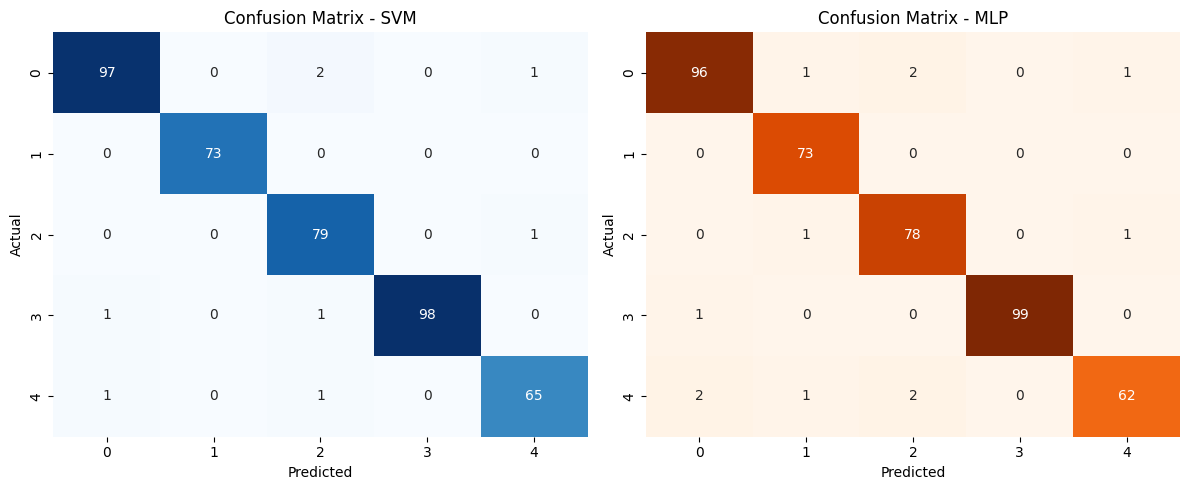

In [ ]:
# Phân tích độ chính xác của SVM và MLP
svm_accuracy = accuracy_score(y_test, svm_pred)
mlp_accuracy = accuracy_score(y_test, mlp_pred)

print("Accuracy of SVM:", svm_accuracy)
print("Accuracy of MLP:", mlp_accuracy)

# Phân tích độ chính xác của từng lớp
svm_report = classification_report(y_test, svm_pred)
mlp_report = classification_report(y_test, mlp_pred)

print("Classification Report of SVM:\n", svm_report)
print("Classification Report of MLP:\n", mlp_report)

# Vẽ biểu đồ confusion matrix
svm_cm = confusion_matrix(y_test, svm_pred)
mlp_cm = confusion_matrix(y_test, mlp_pred)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(svm_cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(mlp_cm, annot=True, cmap='Oranges', fmt='g', cbar=False)
plt.title('Confusion Matrix - MLP')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()